In [1]:
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join
from collections import Counter

In [2]:
folder = './data/'
files = [f for f in listdir(folder) if isfile(join(folder, f))]
print('Amount of the files:', len(files))

# sample屬於哪種 malware family
malware_family = pd.read_csv("./dataset.csv")
malware_family

Amount of the files: 1720


C:\Users\cherry\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,filename,label,threshold(report >= 5),CPU Architecture
0,6727b9dcc9db82a3de5096edfdc873aa0f6e8e3c28704d...,Mirai,True,unknown
1,67a4ecd639251923637abf87927a2d000e5ed795c45bba...,Bashlite,True,armel
2,67978fe14bbaa973412f5fd2d80bf8cf5205607004e0c4...,Mirai,True,armel
3,67c690b32b2d8667f0931952dcafb36c498f167cf355ff...,Unknown,False,x86el
4,6737cb775774a9c0f3991a0b563c86f73402c9ae46751c...,Mirai,True,ppceb
...,...,...,...,...
279882,1e21f6257122dbb017de24aa2329c94157833dd17455a7...,BenignWare,None,mipseb
279883,1e36b2e47f6a8c41d4849404d72d4bd808c62bcc8df0a3...,BenignWare,None,armel
279884,1e33231803460d942dbbf0477da5db71f211b0e887e55c...,BenignWare,None,mips64eb
279885,1ed5d0037e5b51e4040fa1ecdf5983138a041470c8d04c...,BenignWare,None,mipseb


In [3]:
counter = Counter(malware_family['label'])
counter

Counter({'Mirai': 72644,
         'Bashlite': 48094,
         'Unknown': 15223,
         'Android': 6712,
         'Tsunami': 2796,
         'Hajime': 635,
         'Dofloo': 2044,
         'Xorddos': 633,
         'Pnscan': 24,
         'BenignWare': 131082})

In [4]:
mal_type = 'Mirai'
mal_list = malware_family[malware_family['label'] == mal_type]['filename'].tolist()

benign_type = 'Bashlite' # pretend this as benign-ware
benign_list = malware_family[malware_family['label'] == benign_type]['filename'].tolist()

In [5]:
X_mal = [] # M
X_benign = [] # B
l = 300
for file in files:
    if file[:-4] in mal_list:
        data = pd.read_csv(folder + file)['SYSCALL']
        seq= data.tolist()[:l]
        if len(seq) >= l:
            X_mal.append(seq)
            
    elif file[:-4] in benign_list:
        data = pd.read_csv(folder + file)['SYSCALL']
        seq= data.tolist()[:l]
        if len(seq) >= l:
            X_benign.append(seq)

C:\Users\cherry\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (3,6,8,12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\cherry\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\cherry\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (6,8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\cherry\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (6,7,11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell

In [6]:
print(len(X_mal))
print(len(X_benign))

420
300


In [7]:
X_mal = np.array(X_mal)
X_benign = np.array(X_benign)

X = np.concatenate([X_benign, X_mal])
Y = np.zeros(len(X))
Y[len(X_benign):] = 1

In [8]:
unique, counts = np.unique(X, return_counts=True)
#dict(zip(unique, counts))

A = unique.tolist() # the set of all API calls
len(A)

160

In [9]:
def x_in_y(query, base):
    l = len(query)
    for i in range(len(base)):
        if base[i:i+l] == query:
            return True
    return False

def F(d, ng):
    # 分母: len(d)
    count = 0
    for seq in d:
        if x_in_y(ng, seq):
            count += 1
    return count / float(len(d))


def encode(A, s):
    result = []
    for i in range(len(s)):
        for j in range(len(A)):
            if s[i] == A[j]:
                result.append(j)
                break
    return result

In [10]:
M = [] # encode both malware and benign-ware sample to int sequence
B = []

for i in range(len(X_mal)):
    M.append(encode(A, X_mal[i]))

for i in range(len(X_benign)):
    B.append(encode(A, X_benign[i]))

In [11]:
F(B, [19])

0.006666666666666667

In [30]:
[20] in B[0]

False

In [28]:
B[0]

[20,
 144,
 144,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,
 149,

In [12]:
# train a random forest malware detector
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=66)
rf.fit(np.array(B + M), Y)

from sklearn.metrics import accuracy_score

print('train acc:', accuracy_score(Y, rf.predict(np.array(B + M))))

train acc: 1.0


In [13]:
np.array(B + M).shape

(720, 300)

In [17]:
np.save('X', np.array(B + M))
np.save('Y', Y)
np.save('B', B)
np.save('M', M)

In [23]:
import matplotlib.pyplot as plt

def feature_level_attack(model, x, A, total_round = 10):
    # model: trained model detector
    # x: input api sequence with length l
    # A: set of api call
    r = 1 # round 
    x_star = x
    
    class_0_prob = []
    class_1_prob = []
    
    while(model.predict(x_star) == 1):
        print('round ', r)
        r += 1
        
        i = np.random.randint(0, l-1)
        max_F = 0
        max_idx = 0
        for idx in range(len(A)):
            f = F(B, [x_star[0, i]] + [idx]) - F(M, [x_star[0, i]] + [idx])
            print(f)
            if f > max_F:
                #print(f, max_F)
                max_F = f
                max_idx = idx
                
        
        x_star = np.concatenate((x_star[0, 1:i], [max_idx], x_star[0, i:])).reshape(1, -1)
        #print([x_star])
        prob = model.predict_proba(x_star)
        print(prob)
        class_0_prob.append(prob[0, 0])
        class_1_prob.append(prob[0, 1])
        
        # If the loop doesn't stop after r round, just exit.
        if r == (total_round + 1):
            break
    plt.plot(np.arange(len(class_0_prob)) + 1, class_0_prob)
    plt.plot(np.arange(len(class_1_prob)) + 1, class_1_prob)
    plt.show()
    return x_star

round  1
[[0.03 0.97]]
round  2
[[0.06 0.94]]
round  3
[[0.02 0.98]]
round  4
[[0.2 0.8]]
round  5
[[0.1 0.9]]
round  6
[[0.15 0.85]]
round  7
[[0.1 0.9]]
round  8
[[0.13 0.87]]
round  9
[[0.22 0.78]]
round  10
[[0.17 0.83]]
round  11
[[0.12 0.88]]
round  12
[[0.13 0.87]]
round  13
[[0.11 0.89]]
round  14
[[0.11 0.89]]
round  15
[[0.09 0.91]]
round  16
[[0.08 0.92]]
round  17
[[0.08 0.92]]
round  18
[[0.06 0.94]]
round  19
[[0.1 0.9]]
round  20
[[0.1 0.9]]
round  21
[[0.12 0.88]]
round  22
[[0.12 0.88]]
round  23
[[0.15 0.85]]
round  24
[[0.14 0.86]]
round  25
[[0.14 0.86]]
round  26
[[0.14 0.86]]
round  27
[[0.19 0.81]]
round  28
[[0.15 0.85]]
round  29
[[0.24 0.76]]
round  30
[[0.23 0.77]]
round  31
[[0.09 0.91]]
round  32
[[0.24 0.76]]
round  33
[[0.31 0.69]]
round  34
[[0.24 0.76]]
round  35
[[0.42 0.58]]
round  36
[[0.35 0.65]]
round  37
[[0.42 0.58]]
round  38
[[0.45 0.55]]
round  39
[[0.42 0.58]]
round  40
[[0.51 0.49]]
round  1
[[0.08 0.92]]
round  2
[[0.09 0.91]]
round  3
[[0.

[[0.22 0.78]]
round  26
[[0.09 0.91]]
round  27
[[0.08 0.92]]
round  28
[[0.08 0.92]]
round  29
[[0.08 0.92]]
round  30
[[0.15 0.85]]
round  31
[[0.14 0.86]]
round  32
[[0.19 0.81]]
round  33
[[0.14 0.86]]
round  34
[[0.16 0.84]]
round  35
[[0.27 0.73]]
round  36
[[0.2 0.8]]
round  37
[[0.21 0.79]]
round  38
[[0.2 0.8]]
round  39
[[0.37 0.63]]
round  40
[[0.27 0.73]]
round  41
[[0.39 0.61]]
round  42
[[0.28 0.72]]
round  43
[[0.36 0.64]]
round  44
[[0.35 0.65]]
round  45
[[0.35 0.65]]
round  46


ValueError: X has 301 features, but DecisionTreeClassifier is expecting 300 features as input.

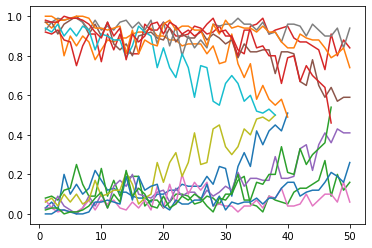

In [45]:
# generate AE sample from the given malware call sequence
AE_sample = []
for i in range(50):
    try:
        x = feature_level_attack(rf, np.array(M[i]).reshape(1, -1), A, 50)
        AE_sample.append(np.array(x))
    except:
        pass

round  1
[[0.03 0.97]]
round  2
[[0.05 0.95]]
round  3
[[0.01 0.99]]
round  4
[[0.18 0.82]]
round  5
[[0.1 0.9]]
round  6
[[0.16 0.84]]
round  7
[[0.1 0.9]]
round  8
[[0.15 0.85]]
round  9
[[0.26 0.74]]
round  10
[[0.16 0.84]]
round  11
[[0.12 0.88]]
round  12
[[0.13 0.87]]
round  13
[[0.11 0.89]]
round  14
[[0.06 0.94]]
round  15
[[0.14 0.86]]
round  16
[[0.08 0.92]]
round  17
[[0.11 0.89]]
round  18
[[0.06 0.94]]
round  19
[[0.11 0.89]]
round  20
[[0.14 0.86]]
round  21
[[0.12 0.88]]
round  22
[[0.11 0.89]]
round  23
[[0.18 0.82]]
round  24
[[0.16 0.84]]
round  25
[[0.2 0.8]]
round  26
[[0.19 0.81]]
round  27
[[0.26 0.74]]
round  28
[[0.18 0.82]]
round  29
[[0.17 0.83]]
round  30
[[0.18 0.82]]
round  31
[[0.23 0.77]]
round  32
[[0.17 0.83]]
round  33
[[0.3 0.7]]
round  34
[[0.4 0.6]]
round  35
[[0.45 0.55]]
round  36
[[0.34 0.66]]
round  37
[[0.45 0.55]]
round  38
[[0.5 0.5]]
round  1
[[0.06 0.94]]
round  2
[[0.04 0.96]]
round  3
[[0.05 0.95]]
round  4
[[0.12 0.88]]
round  5
[[0.16 0

[[0.06 0.94]]
round  11
[[0.01 0.99]]
round  12
[[0.09 0.91]]
round  13
[[0.08 0.92]]
round  14
[[0.12 0.88]]
round  15
[[0.11 0.89]]
round  16
[[0.15 0.85]]
round  17
[[0.19 0.81]]
round  18
[[0.21 0.79]]
round  19
[[0.19 0.81]]
round  20
[[0.1 0.9]]
round  21
[[0.15 0.85]]
round  22
[[0.07 0.93]]
round  23
[[0.08 0.92]]
round  24
[[0.09 0.91]]
round  25
[[0.07 0.93]]
round  26
[[0.06 0.94]]
round  27
[[0.13 0.87]]
round  28
[[0.19 0.81]]
round  29
[[0.14 0.86]]
round  30
[[0.11 0.89]]
round  31
[[0.13 0.87]]
round  32
[[0.21 0.79]]
round  33
[[0.18 0.82]]
round  34
[[0.13 0.87]]
round  35
[[0.13 0.87]]
round  36
[[0.2 0.8]]
round  37
[[0.23 0.77]]
round  38
[[0.19 0.81]]
round  39
[[0.31 0.69]]
round  40
[[0.31 0.69]]
round  41
[[0.37 0.63]]
round  42
[[0.44 0.56]]
round  43
[[0.44 0.56]]
round  44
[[0.44 0.56]]
round  45
[[0.35 0.65]]
round  46
[[0.32 0.68]]
round  47
[[0.35 0.65]]
round  48
[[0.51 0.49]]
round  1
[[0.1 0.9]]
round  2
[[0.15 0.85]]
round  3
[[0.2 0.8]]
round  4
[[0.

[[0.06 0.94]]
round  3
[[0.04 0.96]]
round  4
[[0.03 0.97]]
round  5
[[0.03 0.97]]
round  6
[[0.06 0.94]]
round  7
[[0.02 0.98]]
round  8
[[0.02 0.98]]
round  9
[[0. 1.]]
round  10
[[0. 1.]]
round  11
[[0.05 0.95]]
round  12
[[0.08 0.92]]
round  13
[[0.07 0.93]]
round  14
[[0.17 0.83]]
round  15
[[0.14 0.86]]
round  16
[[0.12 0.88]]
round  17
[[0.16 0.84]]
round  18
[[0.13 0.87]]
round  19
[[0.19 0.81]]
round  20
[[0.15 0.85]]
round  21
[[0.15 0.85]]
round  22
[[0.14 0.86]]
round  23
[[0.07 0.93]]
round  24
[[0.07 0.93]]
round  25
[[0.1 0.9]]
round  26
[[0.07 0.93]]
round  27
[[0.15 0.85]]
round  28
[[0.13 0.87]]
round  29
[[0.13 0.87]]
round  30
[[0.23 0.77]]
round  31
[[0.16 0.84]]
round  32
[[0.22 0.78]]
round  33
[[0.31 0.69]]
round  34
[[0.34 0.66]]
round  35
[[0.22 0.78]]
round  36
[[0.37 0.63]]
round  37
[[0.4 0.6]]
round  38
[[0.26 0.74]]
round  39
[[0.34 0.66]]
round  40
[[0.29 0.71]]
round  41
[[0.26 0.74]]
round  42
[[0.3 0.7]]
round  43
[[0.43 0.57]]
round  44
[[0.4 0.6]]
r

[[0.14 0.86]]
round  3
[[0.07 0.93]]
round  4
[[0.16 0.84]]
round  5
[[0.15 0.85]]
round  6
[[0.16 0.84]]
round  7
[[0.17 0.83]]
round  8
[[0.19 0.81]]
round  9
[[0.19 0.81]]
round  10
[[0.18 0.82]]
round  11
[[0.2 0.8]]
round  12
[[0.17 0.83]]
round  13
[[0.21 0.79]]
round  14
[[0.2 0.8]]
round  15
[[0.17 0.83]]
round  16
[[0.17 0.83]]
round  17
[[0.23 0.77]]
round  18
[[0.24 0.76]]
round  19
[[0.24 0.76]]
round  20
[[0.13 0.87]]
round  21
[[0.19 0.81]]
round  22
[[0.2 0.8]]
round  23
[[0.24 0.76]]
round  24
[[0.13 0.87]]
round  25
[[0.22 0.78]]
round  26
[[0.21 0.79]]
round  27
[[0.22 0.78]]
round  28
[[0.17 0.83]]
round  29
[[0.19 0.81]]
round  30
[[0.16 0.84]]
round  31
[[0.14 0.86]]
round  32
[[0.24 0.76]]
round  33
[[0.24 0.76]]
round  34
[[0.21 0.79]]
round  35
[[0.22 0.78]]
round  36
[[0.16 0.84]]
round  37
[[0.24 0.76]]
round  38
[[0.2 0.8]]
round  39
[[0.3 0.7]]
round  40
[[0.22 0.78]]
round  41
[[0.25 0.75]]
round  42
[[0.25 0.75]]
round  43
[[0.3 0.7]]
round  44
[[0.33 0.67

[[0.18 0.82]]
round  9
[[0.18 0.82]]
round  10
[[0.24 0.76]]
round  11
[[0.21 0.79]]
round  12
[[0.23 0.77]]
round  13
[[0.2 0.8]]
round  14
[[0.23 0.77]]
round  15
[[0.12 0.88]]
round  16
[[0.15 0.85]]
round  17
[[0.1 0.9]]
round  18
[[0.14 0.86]]
round  19
[[0.19 0.81]]
round  20
[[0.19 0.81]]
round  21
[[0.22 0.78]]
round  22
[[0.2 0.8]]
round  23
[[0.19 0.81]]
round  24
[[0.36 0.64]]
round  25
[[0.25 0.75]]
round  26
[[0.12 0.88]]
round  27
[[0.23 0.77]]
round  28
[[0.16 0.84]]
round  29
[[0.25 0.75]]
round  30
[[0.18 0.82]]
round  31
[[0.18 0.82]]
round  32
[[0.21 0.79]]
round  33
[[0.22 0.78]]
round  34
[[0.16 0.84]]
round  35
[[0.27 0.73]]
round  36
[[0.19 0.81]]
round  37
[[0.22 0.78]]
round  38
[[0.19 0.81]]
round  39
[[0.24 0.76]]
round  40
[[0.31 0.69]]
round  41
[[0.36 0.64]]
round  42
[[0.25 0.75]]
round  43
[[0.32 0.68]]
round  44
[[0.23 0.77]]
round  45
[[0.31 0.69]]
round  46
[[0.34 0.66]]
round  47
[[0.31 0.69]]
round  48
[[0.51 0.49]]
round  1
[[0.03 0.97]]
round  2
[

[[0.52 0.48]]
round  1
[[0.06 0.94]]
round  2
[[0.02 0.98]]
round  3
[[0.08 0.92]]
round  4
[[0.04 0.96]]
round  5
[[0.06 0.94]]
round  6
[[0.03 0.97]]
round  7
[[0.06 0.94]]
round  8
[[0.05 0.95]]
round  9
[[0.03 0.97]]
round  10
[[0.03 0.97]]
round  11
[[0.03 0.97]]
round  12
[[0.02 0.98]]
round  13
[[0. 1.]]
round  14
[[0.09 0.91]]
round  15
[[0.09 0.91]]
round  16
[[0.1 0.9]]
round  17
[[0.24 0.76]]
round  18
[[0.13 0.87]]
round  19
[[0.11 0.89]]
round  20
[[0.1 0.9]]
round  21
[[0.16 0.84]]
round  22
[[0.2 0.8]]
round  23
[[0.21 0.79]]
round  24
[[0.14 0.86]]
round  25
[[0.18 0.82]]
round  26
[[0.12 0.88]]
round  27
[[0.04 0.96]]
round  28
[[0.23 0.77]]
round  29
[[0.08 0.92]]
round  30
[[0.08 0.92]]
round  31
[[0.08 0.92]]
round  32
[[0.19 0.81]]
round  33
[[0.14 0.86]]
round  34
[[0.16 0.84]]
round  35
[[0.15 0.85]]
round  36
[[0.16 0.84]]
round  37
[[0.21 0.79]]
round  38
[[0.28 0.72]]
round  39
[[0.24 0.76]]
round  40
[[0.2 0.8]]
round  41
[[0.26 0.74]]
round  42
[[0.14 0.86]]

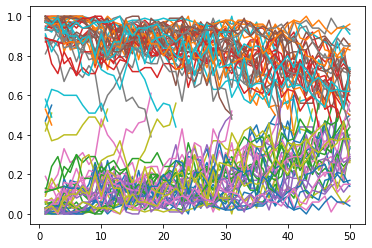

In [47]:
# generate AE sample from the given malware call sequence
AE_sample = []
for i in range(50):
    print('sample', i)
    try:
        x = feature_level_attack(rf, np.array(M[i]).reshape(1, -1), A, 50)
        AE_sample.append(np.array(x))
    except:
        print('error occurs')
        pass

In [66]:
result = rf.predict(np.array(AE_sample).reshape(len(AE_sample), l))
print(result.sum(), '/', len(AE_sample), '=', result.sum() / len(AE_sample))
print(result)

23.0 / 45 = 0.5111111111111111
[0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1.]
